In [2]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', 1000)
import matplotlib.pyplot as plt
import numpy as np


## Predicting Quality in the UCI Wine Quality Dataset - Classification or Regression?

Choosing between classification and regression for the UCI wine quality dataset with a quality scale of 3 (poor) to 9 (excellent) depends on your needs:

* Classification:  If the specific quality level (e.g., good vs bad for bottling) is crucial, then multi-class classification with 7 classes (one for each quality level) might be better.

* Regression: If you need a more precise prediction of the quality score for various purposes (e.g., pricing, blending), then regression could be a good choice. TF-Decision Forests (TF-DF) regression models can handle the integer target variable (quality score) as long as it represents a continuous ordering.

---

Additional Considerations:

* The dataset has an imbalanced class distribution (more "average" wines than high or low quality), which can be a challenge for classification algorithms and would require label engineering or sampling techniques.
* When using a CART model within TF-DF for regression, it's important to specify the task as "regression" during model building.


In [3]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

dataset = X.join(y)

# metadata
for k in ["num_instances", "num_features", "target_col", "has_missing_values"]: print(f"{k}:", wine_quality.metadata[k])

label = "quality"

# variable information
print("\n",wine_quality.variables)

num_instances: 4898
num_features: 11
target_col: ['quality']
has_missing_values: no

                     name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_valu

<Axes: >

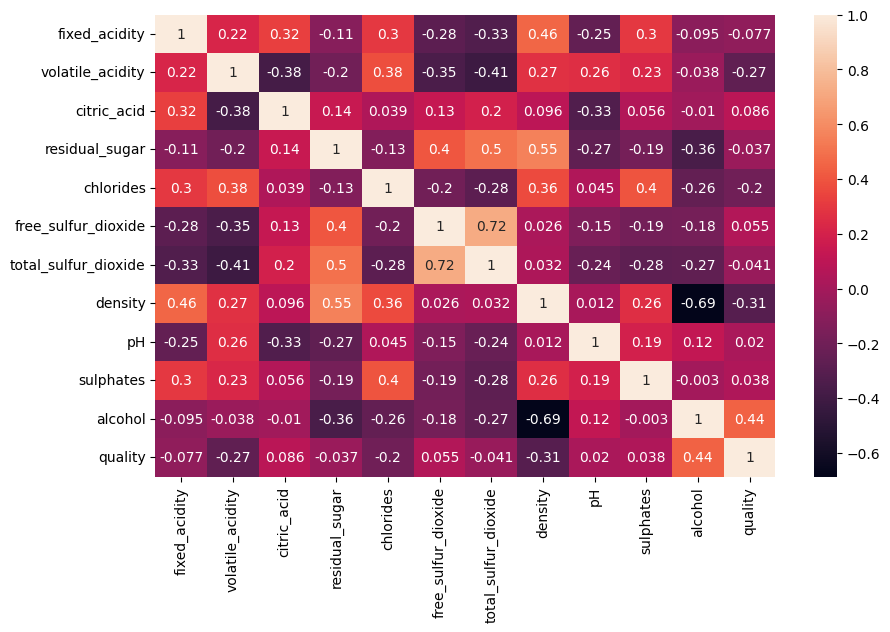

In [4]:
plt.figure(figsize=(10,6))
sns.heatmap(dataset.corr(), annot=True)

In [5]:
print(y.value_counts().sort_index(), "There is a class imbalence across the quality label \nIntuitivly the true distribution of quality wines is normally distributed ", sep= "\n")

quality
3            30
4           216
5          2138
6          2836
7          1079
8           193
9             5
dtype: int64
There is a class imbalence across the quality label 
Intuitivly the true distribution of quality wines is normally distributed 


# Data Split


In [6]:
np.random.seed(5)
# Use the ~25% of the examples as the testing set
# and the remaining ~75% of the examples as the training set.
test_indices = np.random.rand(len(dataset)) < 0.25
pd_train_dataset = dataset[~test_indices]
pd_test_dataset = dataset[test_indices]

print("Total Dataset: ", len(dataset[label]))
print(dataset[label].describe())

print("\nTraining examples: ", len(pd_train_dataset))
print(pd_train_dataset[label].describe())

print("\nTesting examples: ", len(pd_test_dataset))
print(pd_test_dataset[label].describe())


Total Dataset:  6497
count    6497.000000
mean        5.818378
std         0.873255
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

Training examples:  4941
count    4941.000000
mean        5.823315
std         0.877376
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

Testing examples:  1556
count    1556.000000
mean        5.802699
std         0.860131
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64


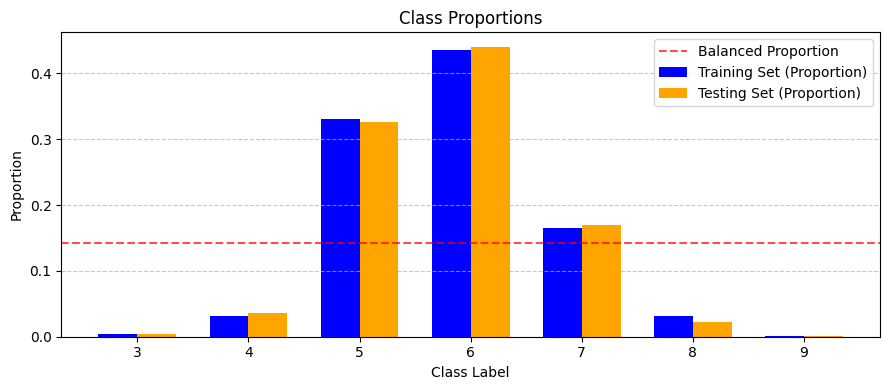

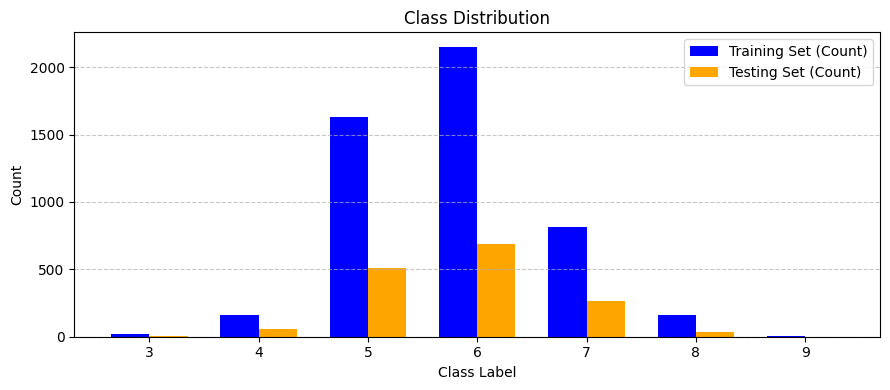

In [8]:
def plot_class_distribution(train_data, test_data, label, normalize=False):
  """
  Plots the class distribution (counts or proportions) for training and testing data using separate bars.

  Args:
      train_data (pandas.DataFrame): Training data.
      test_data (pandas.DataFrame): Testing data.
      label (str): Name of the label column.
      normalize (bool, optional): Whether to normalize counts to proportions. Defaults to False.
  """

  # Calculate class counts only once
  class_counts_train = train_data[label].value_counts(normalize=normalize, sort=False).sort_index()
  class_counts_test = test_data[label].value_counts(normalize=normalize, sort=False).sort_index()

  num_classes = len(class_counts_train)

  # Create the plot with consistent bar width
  plt.figure(figsize=(9, 4))

  x = range(num_classes)
  bar_width = 0.35  # Adjust bar width for separation

  # Separate bars for proportions (if normalize) or counts (default)
  if normalize:
      plt.bar(x, class_counts_train.values, bar_width, label='Training Set (Proportion)', color='blue')
      plt.bar([i + bar_width for i in x], class_counts_test.values, bar_width, label='Testing Set (Proportion)', color='orange')
      plt.axhline(y=1.0 / num_classes, color='red', linestyle='--', alpha=0.7, label='Balanced Proportion')
      plt.ylabel("Proportion")
  else:
      plt.bar(x, class_counts_train.values, bar_width, label='Training Set (Count)', color='blue')
      plt.bar([i + bar_width for i in x], class_counts_test.values, bar_width, label='Testing Set (Count)', color='orange')
      plt.ylabel("Count")

  # Use sorted class labels for xticks
  plt.xticks([i + bar_width / 2 for i in range(num_classes)], class_counts_train.index, rotation=0)

  # Title and legend
  plt.title("Class Distribution" if not normalize else "Class Proportions")
  plt.xlabel("Class Label")
  plt.legend()
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  plt.tight_layout()
  plt.show()

# Example Usage (Plot with proportions)
plot_class_distribution(pd_train_dataset, pd_test_dataset, label, normalize=True)
plot_class_distribution(pd_train_dataset, pd_test_dataset, label, normalize=False)